In [5]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 2.2 MB/s eta 0:00:00a 0:00:01


In [12]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-macosx_11_0_arm64.whl size=58058 sha256=8bfa16b93c2a03bfb55cfb3b0641a341291b6b071bd44ce7e280014da1e29d47
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


In [6]:
!pip install stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=fad001f42919da8650e4b3a064723569021340caac0511008cba9fc30c73566f
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/8f/a5/51/a5405e1da5d178491b79d12cc81b6cb9bb14fe2c8c632eba70
Successfully built stop_words


In [1]:
import os
import re
import string
import annoy
import numpy as np
import pandas as pd
import umap.umap_ as umap
from pymorphy3 import MorphAnalyzer
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

In [2]:
data = pd.read_csv('data/telegram_posts.csv')

In [3]:
data = data.drop('Unnamed: 0', axis=1).drop('message_id', axis=1)

In [4]:
data['clean_text'] = data['message_text'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).replace(r'\n',' ',regex=True).replace(r'[a-zA-Z]', '', regex=True).str.lower()
text = data['clean_text']
text

0       как красиво макияж от                         ...
1       девочки отдельное спасибо хочу сказать что дов...
2       5 часов сидения на жопке конечно того стоят ра...
3          карандаш с индивидуальным наконечником 2 в ...
4       выложила свой стандартный макияж небольшой кус...
                              ...                        
2447    ну и самое важное то что игнорят почти все это...
2448    чтобы не быть голословной покажу свой любимый ...
2449    вообще пигменты сверху фото это лучшее что ест...
2450    немного не моя тема делать обзор на съёмки но ...
2451    свершилось я тут подумала что раз уж я трачу т...
Name: clean_text, Length: 2452, dtype: object

## Преподготовка данных

In [5]:
exclude = set(string.punctuation) # удаление пунктуации
stop_w = set(get_stop_words(language='ru')) # удаление стоп-слов
morpher = MorphAnalyzer() # леммантизатор

In [6]:
symbols_pattern = re.compile(pattern = "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)                        
    "@_!#$%^&*()<>?/\|}{~:√•"
                       "]+", flags = re.UNICODE)
# двойные пробелы
space_pattern = re.compile('\s+')

In [7]:
def clear_text(text):
    """ Функция удаления спецсимволов"""
    pre = symbols_pattern.sub(r'',text)
    # удаление двойных пробелов
    
    return space_pattern.sub(' ', pre)

In [8]:
def preprocess_text(text):
    """ Финальная функция для обработки """
    # srip + lower + punctuation
    sentence = (
        ''.join([x for x in str(text).strip().lower() if x not in exclude])
    )
    # лемматизация и стопслова
    sentence = (
        ' '.join([
            morpher.parse(word)[0].normal_form 
            for word in sentence.split() 
            if word not in stop_w])
    )
    
    return clear_text(sentence)

In [11]:
data['clean_text'] = data['message_text'].apply(preprocess_text).replace(r'[a-zA-Z]','',regex=True)

In [12]:
tfidf = TfidfVectorizer(max_features=25_000)
text_embeddings = tfidf.fit_transform(data['clean_text']).toarray()

In [13]:
umap = umap.UMAP()
embed_2d = umap.fit_transform(text_embeddings)

## Kmeans clustering

In [14]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(text_embeddings)
data['cluster'] = kmeans.labels_

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


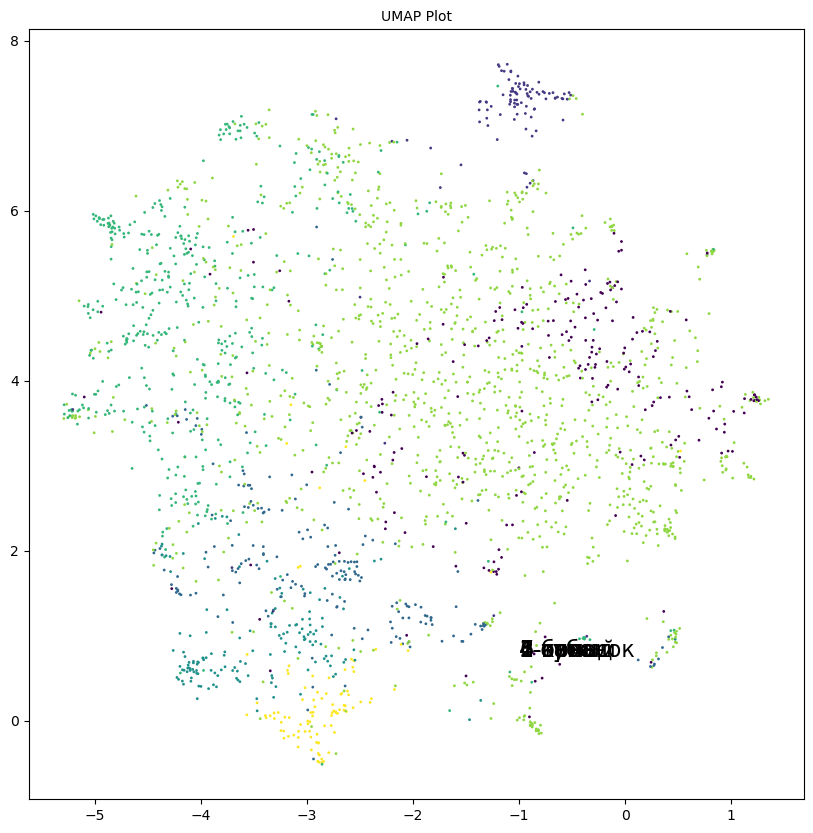

In [15]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:,0], embed_2d[:,1], s=1, c=kmeans.labels_)
plt.title('UMAP Plot',size=10)

for k in range(len(centers)):
    mm = np.mean( text_embeddings[data.cluster.values==k],axis=0 )
    ii = np.argmax(mm)
    top_word = list(tfidf.vocabulary_.keys())[list(tfidf.vocabulary_.values()).index(ii)]
    plt.text(centers[k,0]-1,centers[k,1]+0.75,f'{k+1}-{top_word}',size=16)

plt.show()

In [16]:
#data = data.drop('Unnamed: 0', axis=1).drop('message_id', axis=1)

In [39]:
for k in range(7):
    mm = np.mean(text_embeddings[data.cluster.values==k],axis=0 )
    ii = (np.argsort(mm)[-7:][::-1] )
    top_words = [list(tfidf.vocabulary_.keys())[list(tfidf.vocabulary_.values()).index(i)] for i in ii]
    print('#'*25)
    print(f'### Topic {k+1}')
    print('### Top 5 Words',top_words)
    print('#'*25)
    tmp = data.loc[data.cluster==k].sample(3, random_state=123, replace=True)
    #print(tmp['message_text'].tolist())

#########################
### Topic 1
### Top 5 Words ['бренд', 'канал', 'скидка', 'магазин', 'продукт', 'подборка', 'классный']
#########################
#########################
### Topic 2
### Top 5 Words ['волос', 'шампунь', 'укладка', 'голова', 'маска', 'кондиционер', 'наносить']
#########################
#########################
### Topic 3
### Top 5 Words ['тень', 'оттенок', 'глаз', 'кремовый', 'вообще', 'кисть', 'карандаш']
#########################
#########################
### Topic 4
### Top 5 Words ['оттенок', 'новый', 'кожа', 'матовый', 'румяный', 'пудра', 'помада']
#########################
#########################
### Topic 5
### Top 5 Words ['кожа', 'крем', 'лицо', 'использовать', 'ретинол', 'средство', 'тело']
#########################
#########################
### Topic 6
### Top 5 Words ['самый', 'знать', 'делать', 'вообще', 'хотеть', 'хороший', 'любимый']
#########################
#########################
### Topic 7
### Top 5 Words ['губа', 'блеск', 'бальзам', 

## Оптимальное количество классов по методу Silhouette Score

In [46]:
min_clusters = 2
max_clusters = 20
inertias = []
silhouette_scores = []

In [ ]:
for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(text_embeddings)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(text_embeddings, kmeans.labels_))

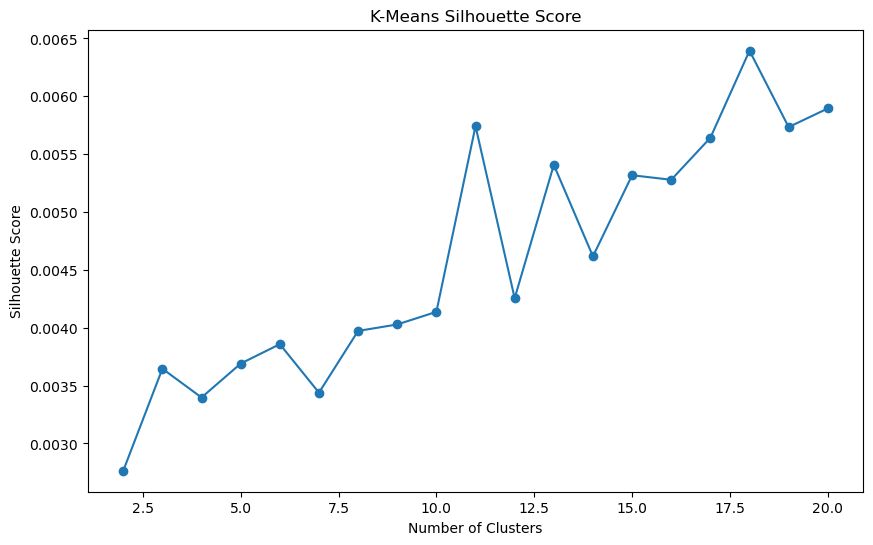

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.title('K-Means Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## LDA  clustering

In [69]:
lda = LatentDirichletAllocation(n_components = 7, max_iter=200, learning_method='online', learning_offset=50.,random_state=0).fit(text_embeddings)

In [70]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [71]:
tfd_feature_names = tfidf.get_feature_names_out()

In [72]:
print_top_words(lda, tfd_feature_names, n_top_words=7)

Topic #0: кожа самый лицо оттенок делать использовать продукт
Topic #1: разводиться песня00 трэвисса понимали кринжао игрок флексе
Topic #2: 74 лемонграсса колючий негинский 989 тряска слетать
Topic #3: хорошая991830714287388890841851876 джинсы блуза стерлинг сетдлиннаяюбкаизполиамида036413131317333034 крыша линза
Topic #4: мерфь хэппи 495 киллиана ищу0020648607512490609157596 резина ларочка
Topic #5: 1081530001 полины мёмный грядущий 2024122024 стивен видосы3690
Topic #6: мэпплторп што 3117355555555555507080901196003214 эээээ джоля оппенгеймер 20241235940343


## MiniBatchKMeans

In [20]:
mbk  = MiniBatchKMeans(n_clusters = 7,
                         random_state=0,
                         batch_size= 50,
                         n_init="auto").fit(text_embeddings)
data['cluster2'] = mbk.labels_

In [21]:
for k in range(7):
    mm = np.mean(text_embeddings[data.cluster2.values==k],axis=0 )
    ii = ( np.argsort(mm)[-7:][::-1] )
    top_words = [list(tfidf.vocabulary_.keys())[list(tfidf.vocabulary_.values()).index(i)] for i in ii]
    print('#'*25)
    print(f'### Topic {k+1}')
    print('### Top 5 Words',top_words)
    print('#'*25)
    tmp = data.loc[data.cluster2==k].sample(3, random_state=123, replace=True)

#########################
### Topic 1
### Top 5 Words ['волос', 'самый', 'делать', 'бренд', 'знать', 'вообще', 'хотеть']
#########################
#########################
### Topic 2
### Top 5 Words ['волос', 'уметь', 'ухоженно', 'облегчать', 'хулиард', 'склеивать', '150']
#########################
#########################
### Topic 3
### Top 5 Words ['32428851396689', 'тело', 'хайлатереть', 'универсальный', 'патрик', 'забывать', 'макияж']
#########################
#########################
### Topic 4
### Top 5 Words ['выгорание', 'жить', 'энергия', 'вернуть', 'привет', 'спец', 'жвачка']
#########################
#########################
### Topic 5
### Top 5 Words ['могилка', 'фуфуфу', 'сфоткайт', 'скорый', 'палящий', 'поход', 'вкусно']
#########################
#########################
### Topic 6
### Top 5 Words ['кожа', 'крем', 'лицо', 'использовать', 'средство', 'ретинол', 'кислота']
#########################
#########################
### Topic 7
### Top 5 Words ['оттенок', 

In [33]:
data.to_csv('data/clustering_data.csv')

In [35]:
data.cluster2.value_counts()

cluster2
0    1789
5     517
6     142
3       1
2       1
1       1
4       1
Name: count, dtype: int64

In [36]:
data.cluster.value_counts()

cluster
5    1213
4     469
0     222
2     195
3     155
1     101
6      97
Name: count, dtype: int64

## Вывод

Выбрано при метода кластеризации: kmeans,  MiniBatchKMeans, LatentDirichletAllocation .
Был рассчитан K-Means Silhouette Score, для определения оптимального числа кластеров. Их оказалось 7.
Был сделан вывод, что LDA дает самые плохие результаты. А kmeans,  MiniBatchKMeans выдают похожие результаты. Но лучше всего себя показал метод Kmeans. Было выделено 7 тематик: 
1) одежда
2) уход за волосами
3) макияж глаз
4) декоративная косметика (кожа)
5) уходовая косметика
6) фавориты 
7) декоративная косметика (губы)